# Préparation des données de notre dataset

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


chemin_fichier = "C:/Users/smala/Documents/life.csv"
data = pd.read_csv(chemin_fichier)

data.columns = data.columns.str.strip()

print("\nRésumé des valeurs manquantes avant suppression :")
print(data.isnull().sum())

# Nous sélectionnons les colonnes nécessaires
selected_columns = [
    'Life expectancy',  # Cible (y)
    'GDP',
    'Status',
    'infant deaths',
    'Alcohol',
    'percentage expenditure',
    'BMI'
]

selected_columns = [col for col in selected_columns if col in data.columns]
data_final = data[selected_columns]

# On supprime les lignes contenant des valeurs manquantes
data_final = data_final.dropna()

# On vérifie les dimensions après suppression
print("\nRésumé des valeurs manquantes après suppression :")
print(data_final.isnull().sum())
print(f"\nDimensions après suppression des lignes avec valeurs manquantes : {data_final.shape}")

# On sépare les vraiables expliquatives de la variable à expliquer
X = data_final.drop(columns=['Life expectancy'])
y = data_final['Life expectancy']

# Vérifier les premières lignes après suppression
print("\nAperçu des données après suppression des valeurs manquantes :")
print(data_final.head())



Résumé des valeurs manquantes avant suppression :
Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

Résumé des valeurs manquantes après suppression :
Life expectancy           0

## Encodage variable catégorielle "statu"

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Encodage de la colonne catégorielle "Status" avec OneHotEncoder
preprocessor = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ['Status']),  # Encodage pour "Status"
    remainder='passthrough'  # Conserver les autres colonnes inchangées
)

# Transformation des données
X_final = preprocessor.fit_transform(X)

print(f"Dimensions de X après encodage : {X_final.shape}")



Dimensions de X après encodage : (2313, 7)


In [5]:
# Modèle avec OOB (Out-Of-Bag)
model_oob = RandomForestRegressor(
    n_estimators=500,  # On génère 500 arbres par defaults .
    oob_score=True,    # Active le calcul de l'erreur Out-Of-Bag.
    random_state=1     # Introduit de l'aleatoire dans les resultats.
)

# Entraînement du modèle sur les données X_final (caractéristiques) et y (cible)
model_oob.fit(X_final, y)

# Calcul du MSE pour les prédictions OOB
oob_predictions = model_oob.oob_prediction_  # On récupère les prédictions Out-Of-Bag pour chaque échantillon.
oob_mse = mean_squared_error(y, oob_predictions)  # On calcule l'erreur quadratique moyenne entre y et les prédictions OOB.
oob_rmse = np.sqrt(oob_mse)  # Calcule la racine carrée du MSE pour obtenir le RMSE.Afin que le resultats soit plus réaliste
oob_r2 = model_oob.oob_score_  # Récupère le score R² calculé sur les prédictions OOB.

# Affichage des performances OOB
print("\n--- Performances OOB ---")
print(f"MSE OOB : {oob_mse:.4f}")  
print(f"RMSE OOB : {oob_rmse:.4f}")  
print(f"R² OOB : {oob_r2:.4f}")  

# Validation croisée avec 5 plis
kf = KFold(
    n_splits=5,      # On divise les données en 5 sous-ensembles (on prend 5 par default dans notre étude).
    shuffle=True,    # On mélange les données avant de les diviser en plis.
    random_state=1  
)

# Calcul de l'erreur quadratique moyenne (MSE) pour chaque pli
cv_mse = -cross_val_score(
    model_oob,          # Utilise le modèle RandomForestRegressor pour la validation croisée.
    X_final,         
    y,                 
    cv=kf,              # Divisions des plis définies par l'objet KFold.
    scoring='neg_mean_squared_error'  # Utilise l'erreur quadratique moyenne comme métrique de validation.
)
cv_mse_mean = cv_mse.mean()  # Calcule le MSE moyen à partir des scores des différents plis.
cv_rmse = np.sqrt(cv_mse_mean)  # Calcule le RMSE 

# Calcul du R² moyen pour la validation croisée
cv_r2 = cross_val_score(model_oob, X_final, y, cv=kf, scoring='r2')
cv_r2_mean = cv_r2.mean()  

# Affichage des performances de la validation croisée
print("\n--- Performances Validation Croisée ---")
print(f"MSE moyen (Validation Croisée) : {cv_mse_mean:.4f}")  
print(f"RMSE moyen (Validation Croisée) : {cv_rmse:.4f}")  
print(f"R² moyen (Validation Croisée) : {cv_r2_mean:.4f}")  


--- Performances OOB ---
MSE OOB : 11.9373
RMSE OOB : 3.4550
R² OOB : 0.8734

--- Performances Validation Croisée ---
MSE moyen (Validation Croisée) : 12.9744
RMSE moyen (Validation Croisée) : 3.6020
R² moyen (Validation Croisée) : 0.8628


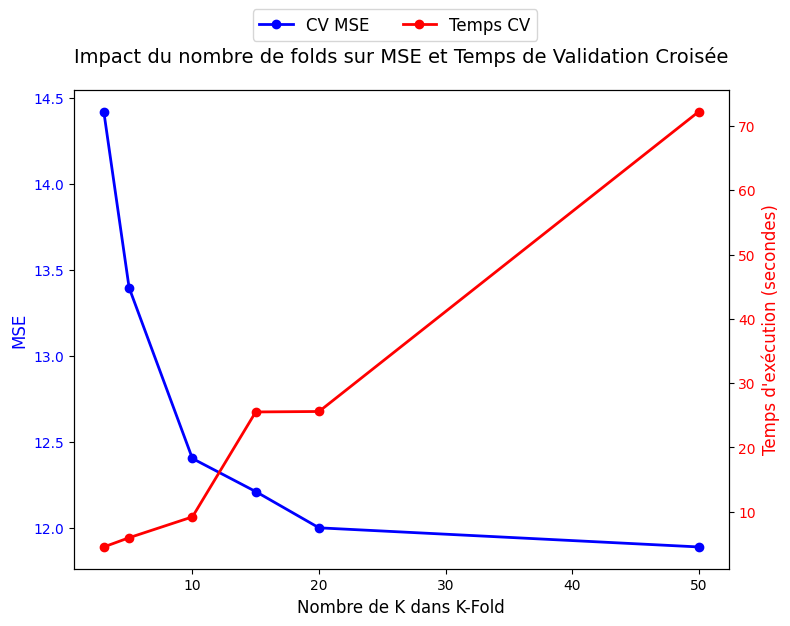

In [ ]:
import time  

#Liste des différentes valeurs de K-folds
k_values = [3, 5, 10, 15, 20, 50]

# Listes pour stocker les résultats
cv_mse_list_k = []
cv_times = []

# Boucle pour tester différentes valeurs de K dans K-Fold
for k in k_values:
    start = time.time()  # Chronomètre

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    cross_val_mse = -cross_val_score(model_oob, X_final, y, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

    end = time.time()  # Arrête le chronomètre 

    cv_mse_list_k.append(cross_val_mse.mean())  # MSE moyen pour cette valeur de K
    cv_times.append(end - start)  # Temps total d'exécution


fig, ax1 = plt.subplots(figsize=(8, 6))  

# Courbe pour le MSE
ax1.plot(k_values, cv_mse_list_k, label='CV MSE', marker='o', color='blue', linewidth=2)
ax1.set_xlabel('Nombre de K dans K-Fold', fontsize=12)
ax1.set_ylabel('MSE', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=10)
ax1.tick_params(axis='x', labelsize=10)

# Courbe pour le temps d'exécution
ax2 = ax1.twinx()
ax2.plot(k_values, cv_times, label='Temps CV', marker='o', color='red', linewidth=2)
ax2.set_ylabel('Temps d\'exécution (secondes)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red', labelsize=10)


fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=12)
plt.title('Impact du nombre de folds sur MSE et Temps de Validation Croisée', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


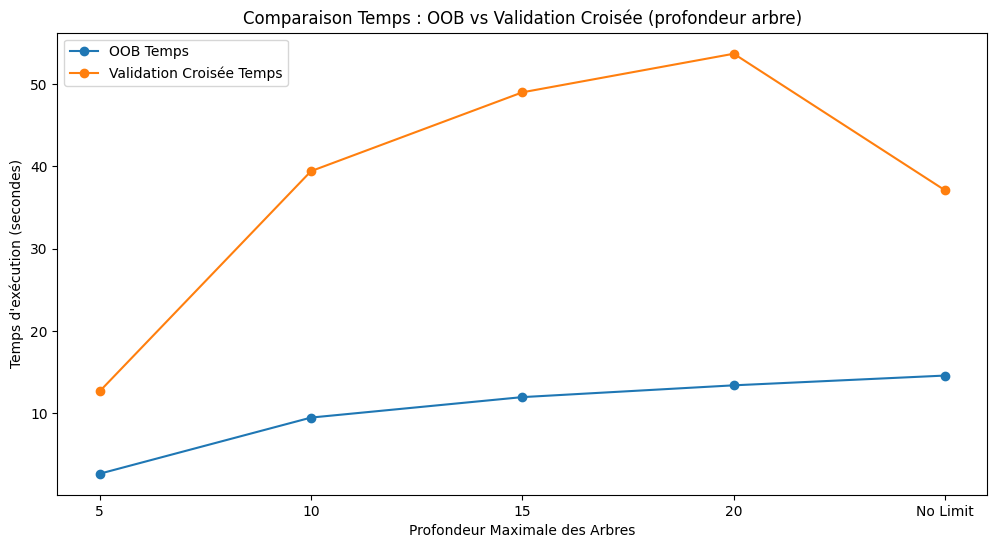

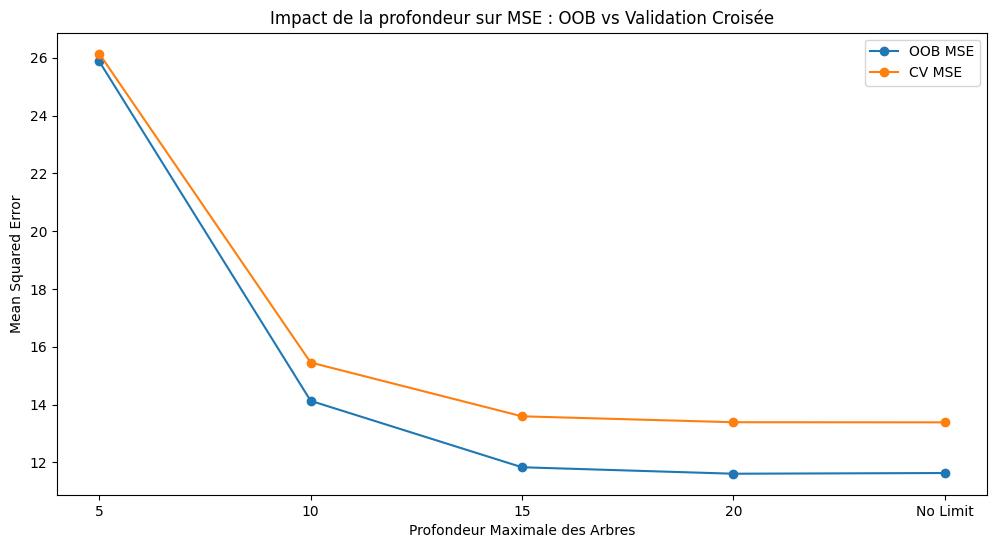

In [8]:
import time  
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import cross_val_score, KFold  
from sklearn.metrics import mean_squared_error 

# Valeurs de profondeur maximale des arbres à tester
max_depth_values = [5, 10, 15, 20, None]  

# Initialisation des listes pour enregistrer les temps d'exécution et les MSE
oob_times = []  
cv_times = [] 
oob_mse_list = [] 
cv_mse_list = []  

# Boucle pour tester différentes profondeurs maximales
for max_depth in max_depth_values:
   
    start_oob = time.time()  # Démarrage du chronomètre pour OOB
    model_oob = RandomForestRegressor(
        n_estimators=500,  # Nombre d'arbres dans la forêt
        oob_score=True,  # Active calculs OOB
        max_depth=max_depth,  # Limite profondeur des arbres
        random_state=42 
    )
    model_oob.fit(X_final, y)  # Entraînement du modèle sur les données
    end_oob = time.time()  # Fin du chronomètre 
    oob_times.append(end_oob - start_oob)  

    # Calcul du MSE pour les prédictions OOB
    if hasattr(model_oob, "oob_prediction_") and not np.any(np.isnan(model_oob.oob_prediction_)):
        oob_mse = mean_squared_error(y, model_oob.oob_prediction_)  
    else:
        oob_mse = np.nan  
    oob_mse_list.append(oob_mse) 

    
    start_cv = time.time()  # Démarrage du chronomètre pour validation croisée
    kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Configuration de la validation croisée (5 plis)
    cv_mse = -cross_val_score(model_oob, X_final, y, cv=kf, scoring="neg_mean_squared_error").mean()  
    end_cv = time.time()  # Fin du chronomètre 
    cv_times.append(end_cv - start_cv)  
    cv_mse_list.append(cv_mse) 



# Convertir None en "No Limit" pour une meilleure lisibilité des étiquettes
depth_labels = [str(d) if d is not None else "No Limit" for d in max_depth_values]

#  Graphique : Temps d'exécution 
plt.figure(figsize=(12, 6))  
plt.plot(depth_labels, oob_times, label="OOB Temps", marker="o")  
plt.plot(depth_labels, cv_times, label="Validation Croisée Temps", marker="o") 
plt.xlabel("Profondeur Maximale des Arbres")  
plt.ylabel("Temps d'exécution (secondes)")  
plt.title("Comparaison Temps : OOB vs Validation Croisée (profondeur arbre)")  
plt.legend() 
plt.show()  

# Graphique : Mean Squared Error (MSE)
plt.figure(figsize=(12, 6))  
plt.plot(depth_labels, oob_mse_list, label="OOB MSE", marker="o", linestyle="-")  
plt.plot(depth_labels, cv_mse_list, label="CV MSE", marker="o", linestyle="-") 
plt.xlabel("Profondeur Maximale des Arbres")  
plt.ylabel("Mean Squared Error")  
plt.title("Impact de la profondeur sur MSE : OOB vs Validation Croisée") 
plt.legend()  
plt.show()  


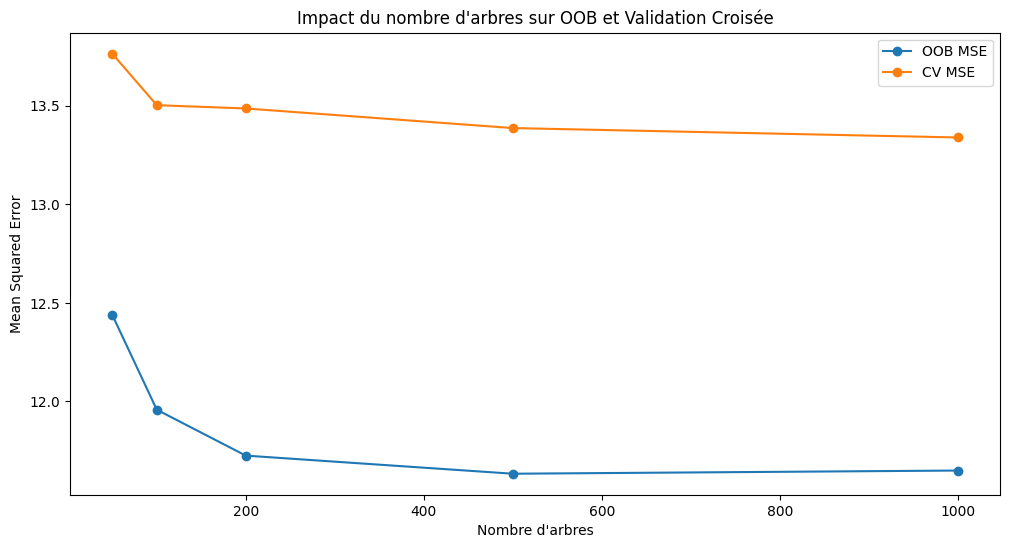

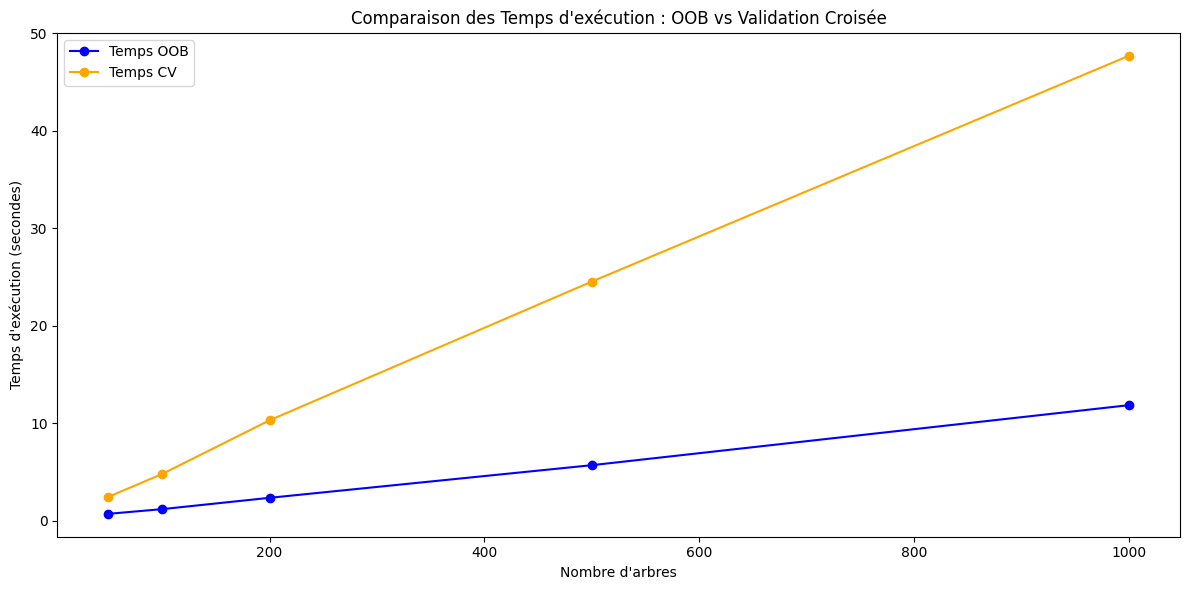

In [10]:
# Définir les valeurs du nombre d'arbres à tester
n_estimators_values = [50, 100, 200, 500, 1000]

# Listes pour stocker les MSE et les temps d'exécution
oob_mse_list = []
cv_mse_list = []
oob_times = []  # Temps pour OOB
cv_times = []   # Temps pour Validation Croisée

for n_estimators in n_estimators_values:
    
    # Mesurer le temps pour OOB
    start_time = time.time()
    model_oob = RandomForestRegressor(n_estimators=n_estimators, oob_score=True, random_state=42)
    model_oob.fit(X_final, y)
    elapsed_time_oob = time.time() - start_time
    oob_times.append(elapsed_time_oob)
    
    # Vérifier et calculer le MSE OOB
    oob_predictions = model_oob.oob_prediction_
    if np.any(np.isnan(oob_predictions)):  # Vérifier la présence de NaN
        print(f"Attention : OOB prédictions manquantes pour n_estimators={n_estimators}")
        oob_mse_list.append(np.nan)
    else:
        oob_mse = mean_squared_error(y, oob_predictions)
        oob_mse_list.append(oob_mse)
    
    # Mesurer le temps pour Validation Croisée
    start_time = time.time()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mse = -cross_val_score(model_oob, X_final, y, cv=kf, scoring='neg_mean_squared_error')
    elapsed_time_cv = time.time() - start_time
    cv_times.append(elapsed_time_cv)
    
    # Calculer le MSE de la validation croisée
    cv_mse_list.append(cv_mse.mean())

# Graphique MSE
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_values, oob_mse_list, label='OOB MSE', marker='o', linestyle='-')
plt.plot(n_estimators_values, cv_mse_list, label='CV MSE', marker='o', linestyle='-')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Mean Squared Error')
plt.title('Impact du nombre d\'arbres sur OOB et Validation Croisée')
plt.legend()

# Graphique Comparaison des Temps d'exécution
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_values, oob_times, label='Temps OOB', marker='o', linestyle='-', color='b')
plt.plot(n_estimators_values, cv_times, label='Temps CV', marker='o', linestyle='-', color='orange')
plt.xlabel('Nombre d\'arbres')
plt.ylabel('Temps d\'exécution (secondes)')
plt.title('Comparaison des Temps d\'exécution : OOB vs Validation Croisée')
plt.legend()

plt.tight_layout()
plt.show()
